In [19]:
import torch
import torch.nn as nn
import argparse
import os
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, Conv2d, MaxPool2d, Module,Flatten,  BatchNorm2d
from torch.optim.lr_scheduler import *
import warnings
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [20]:
NUM_CLASS = 10
NUM_UNTARGET_CLASS = 3
EPOCHS = 20
REPLACE_LST = [7,8,9]

In [21]:
class UnLabel_Dataset(Dataset):
    def __init__(self, imgs, ground_truth, transform):
        self.imgs = imgs
        self.ground_truth = ground_truth
        self.transform = transform
    def __len__(self):
        return len(self.ground_truth)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        tar = self.ground_truth[idx]
        if self.transform:
            img = self.transform(img)
        #print(img.shape,tar.shape)
        return img[None:], tar

In [22]:
class get_img():
    def __init__(self, classes=[]):
        self.classes = classes
    def __call__(self, dataset):
        tensor_targets = torch.tensor(dataset.targets)
        semasks = torch.any(torch.stack( [torch.eq(tensor_targets, aelem).logical_or_(torch.eq(tensor_targets, aelem)) for aelem in self.classes], dim=0), dim = 0)
        imgs = dataset.data[semasks]
        tars = torch.tensor(dataset.targets)[semasks.tolist()].tolist()
        return imgs, tars

In [23]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

train_transforms = [transforms.RandomCrop(32, 4),
                    transforms.ToTensor(),
                    normalize,
                   ]
train_set = datasets.CIFAR10(root="./data", train=True,
                                     transform=transforms.Compose(train_transforms),
                                     download=True)
test_set = datasets.CIFAR10(root="./data", train=False,
                                    transform=transforms.Compose(
                                        [transforms.ToTensor(), normalize]
                                    ))
train_set.data.shape

Files already downloaded and verified


(50000, 32, 32, 3)

In [24]:
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=512,
                                           shuffle=True,
                                           num_workers=2, 
                                           drop_last=False)
test_loader = torch.utils.data.DataLoader(test_set, 
                                           batch_size=1024,
                                           shuffle=False,
                                           num_workers=2, 
                                           drop_last=False)

In [25]:
get_imgs = get_img(REPLACE_LST)
unlabel_training_imgs, ground_truth_training = get_imgs(train_set)
unlabel_training_dataset = UnLabel_Dataset(unlabel_training_imgs,
                                           ground_truth_training,
                                           transform=transforms.Compose([transforms.ToTensor(), normalize])
                                          )
unlabel_training_dataloader = torch.utils.data.DataLoader(unlabel_training_dataset,
                                                          batch_size=512,
                                                          shuffle=False,
                                                          num_workers=2,
                                                          drop_last=False)

get_imgs = get_img(REPLACE_LST)
unlabel_test_imgs, ground_truth_test = get_imgs(test_set)
unlabel_test_dataset = UnLabel_Dataset(unlabel_test_imgs,
                                       ground_truth_test,
                                       transform=transforms.Compose([transforms.ToTensor(), normalize])
                                      )
unlabel_test_dataloader = torch.utils.data.DataLoader(unlabel_test_dataset,
                                                          batch_size=512,
                                                          shuffle=False,
                                                          num_workers=2,
                                                          drop_last=False)


In [26]:
class replace_label():
    def __init__(self, labels=[], tar_label=7):
        super(replace_label, self).__init__()
        if len(labels)!=NUM_UNTARGET_CLASS:
            warnings.warn('Length of labels neq to NUM_UNTARGET_CLASS!')
        self.labels = labels
        self.tar_label = tar_label
    def __call__(self, labels):
        labels_cpy = torch.clone(labels)
        semasks = torch.any(torch.stack( [torch.eq(labels, aelem).logical_or_(torch.eq(labels, aelem)) for aelem in self.labels], dim=0), dim = 0)
        labels_cpy[semasks] = self.tar_label
        return labels_cpy

In [27]:
class CNN(Module):
  def __init__(self, classes):
      super().__init__()
      self.network = Sequential(
          Conv2d(3, 32, kernel_size=3, padding=1),
          ReLU(),
          Conv2d(32, 64, kernel_size=3, padding=1),
          ReLU(),
          MaxPool2d(2, 2), # output: 64 x 16 x 16

          Conv2d(64, 128, kernel_size=3, padding=1),
          ReLU(),
          Conv2d(128, 128, kernel_size=3,padding=1),
          ReLU(),
          MaxPool2d(2, 2), # output: 128 x 8 x 8

          Conv2d(128, 256, kernel_size=3,padding=1),
          ReLU(),
          Conv2d(256, 256, kernel_size=3,padding=1),
          ReLU(),
          MaxPool2d(2, 2), # output: 256 x 4 x 4

          Flatten(), 
          Linear(1 * 4096, 1024),
          ReLU(),
          Linear(1024, 512),
          ReLU(),
          Linear(512, 64),
          ReLU())
      self.lin = Linear(64, classes)
  def feature(self, xb):
      x = self.network(xb)
      return x
  def forward(self, xb):
      x = self.feature(xb)
      # print(x.shape)
      x = self.lin(x)
      return x

In [28]:
model = CNN(classes=NUM_CLASS-NUM_UNTARGET_CLASS+1).cuda()
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                                    momentum=0.9,
                                    nesterov=False)
scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

In [30]:
replace = replace_label(REPLACE_LST, NUM_CLASS-NUM_UNTARGET_CLASS)
def train(model, train_loader, optimizer):
    model = model.to(device)
    model.train()
    num_examples = 0
    correct = 0
    train_loss = 0
    for data, target in tqdm(train_loader):
        target = replace(target)
        data, target = data.to(device), target.to(device)
        #print(target.shape, target)
        output = model(data)
        #print(data.shape,output.shape, target.shape)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += F.cross_entropy(output, target, reduction='sum').item()
        num_examples += len(data)

    train_loss /= num_examples
    train_acc = 100. * correct / num_examples
    print(f'Train set: Average loss: {train_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({train_acc:.2f}%)')
    return train_loss, train_acc

In [33]:
def test(model, test_loader):
    device = next(model.parameters()).device
    
    model.eval()
    num_examples = 0
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader):
            target = replace(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            num_examples += len(data)

    test_loss /= num_examples
    test_acc = 100. * correct / num_examples

    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{num_examples} ({test_acc:.2f}%)')

    return test_loss, test_acc

In [34]:
train_loss_lst=[]
train_acc_lst=[]
val_loss_lst=[]
val_acc_lst=[]
for epoch in range(0, EPOCHS):
    print(f"\nEpoch: {epoch}")
    train_loss, train_acc = train(model, train_lo ader, optimizer)
    test_loss, test_acc = test(model, test_loader)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(test_loss)
    val_acc_lst.append(test_acc)
    scheduler.step()


Epoch: 0


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.9031, Accuracy: 15402/50000 (30.80%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.8006, Accuracy: 3423/10000 (34.23%)

Epoch: 1


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.7191, Accuracy: 17785/50000 (35.57%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.5563, Accuracy: 4001/10000 (40.01%)

Epoch: 2


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.5661, Accuracy: 20378/50000 (40.76%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.4308, Accuracy: 4542/10000 (45.42%)

Epoch: 3


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.4439, Accuracy: 22646/50000 (45.29%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.4198, Accuracy: 4688/10000 (46.88%)

Epoch: 4


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.3358, Accuracy: 24573/50000 (49.15%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.2460, Accuracy: 5341/10000 (53.41%)

Epoch: 5


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.2050, Accuracy: 27339/50000 (54.68%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.0503, Accuracy: 6112/10000 (61.12%)

Epoch: 6


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.1025, Accuracy: 29692/50000 (59.38%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.6986, Accuracy: 3730/10000 (37.30%)

Epoch: 7


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 1.2569, Accuracy: 26538/50000 (53.08%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 1.0747, Accuracy: 6094/10000 (60.94%)

Epoch: 8


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.9746, Accuracy: 32210/50000 (64.42%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.9081, Accuracy: 6718/10000 (67.18%)

Epoch: 9


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.8447, Accuracy: 34657/50000 (69.31%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.8304, Accuracy: 7032/10000 (70.32%)

Epoch: 10


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.6557, Accuracy: 38284/50000 (76.57%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.6497, Accuracy: 7717/10000 (77.17%)

Epoch: 11


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.6003, Accuracy: 39312/50000 (78.62%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.6351, Accuracy: 7763/10000 (77.63%)

Epoch: 12


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.5715, Accuracy: 39840/50000 (79.68%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.6203, Accuracy: 7818/10000 (78.18%)

Epoch: 13


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.5501, Accuracy: 40263/50000 (80.53%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.6070, Accuracy: 7867/10000 (78.67%)

Epoch: 14


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.5330, Accuracy: 40550/50000 (81.10%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.5963, Accuracy: 7905/10000 (79.05%)

Epoch: 15


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.5085, Accuracy: 40950/50000 (81.90%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.5853, Accuracy: 7957/10000 (79.57%)

Epoch: 16


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.4892, Accuracy: 41227/50000 (82.45%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.5769, Accuracy: 7990/10000 (79.90%)

Epoch: 17


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.4763, Accuracy: 41482/50000 (82.96%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.5638, Accuracy: 8022/10000 (80.22%)

Epoch: 18


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.4539, Accuracy: 41966/50000 (83.93%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.5618, Accuracy: 8066/10000 (80.66%)

Epoch: 19


  0%|          | 0/98 [00:00<?, ?it/s]

Train set: Average loss: 0.4377, Accuracy: 42173/50000 (84.35%)


  0%|          | 0/10 [00:00<?, ?it/s]

Test set: Average loss: 0.5562, Accuracy: 8082/10000 (80.82%)


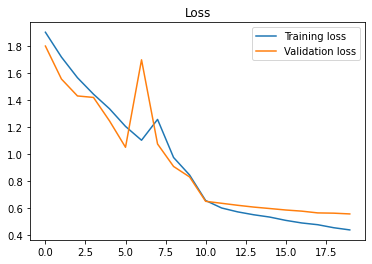

In [35]:
plt.plot(train_loss_lst, label='Training loss')
plt.plot(val_loss_lst, label='Validation loss')
plt.title('Loss')
plt.legend()

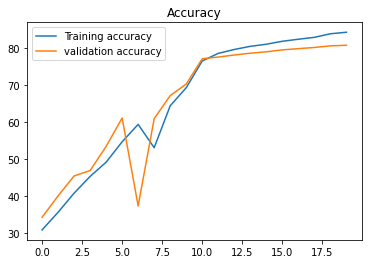

In [36]:
plt.plot(train_acc_lst, label='Training accuracy')
plt.plot(val_acc_lst, label='validation accuracy')
plt.title('Accuracy')
plt.legend()

In [38]:
model.eval()
unlabel_features_training = torch.empty((0,64))
grand_truth_training = torch.empty((0))
for data, target in tqdm(unlabel_training_dataloader):
    data, target = data.to(device), target
    feature = model.feature(data)
    unlabel_features_training = torch.cat((unlabel_features_training,feature.detach().cpu()), 0)
    grand_truth_training = torch.cat((grand_truth_training, target), 0)
unlabel_features_training = unlabel_features_training.numpy()
grand_truth_training = grand_truth_training.numpy()
print(unlabel_features_training.shape)
print(grand_truth_training.shape)

  0%|          | 0/30 [00:00<?, ?it/s]

(15000, 64)
(15000,)


In [39]:
model.eval()
unlabel_features_test = torch.empty((0,64))
grand_truth_test = torch.empty((0))
for data, target in tqdm(unlabel_test_dataloader):
    data, target = data.to(device), target
    feature = model.feature(data)
    unlabel_features_test = torch.cat((unlabel_features_test,feature.detach().cpu()), 0)
    grand_truth_test = torch.cat((grand_truth_test, target), 0)
unlabel_features_test = unlabel_features_test.numpy()
grand_truth_test = grand_truth_test.numpy()
print(unlabel_features_test.shape)
print(grand_truth_test.shape)

  0%|          | 0/6 [00:00<?, ?it/s]

(3000, 64)
(3000,)


In [40]:
GMM = GaussianMixture(n_components=NUM_UNTARGET_CLASS).fit(unlabel_features_training)

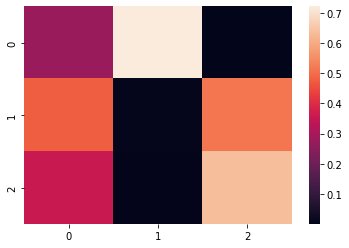

In [41]:
p = GMM.predict(unlabel_features_test)
match_map = np.zeros((len(REPLACE_LST),len(np.unique(p))))
for grand_truth_idx, tar in enumerate(REPLACE_LST):
    for pred_idx, p_tar in enumerate(np.unique(p)):
        g_eq = grand_truth_test==tar
        pred_= p==p_tar
        match_map[grand_truth_idx, pred_idx] = np.sum(g_eq&pred_)/1000
sns.heatmap(match_map)

In [42]:
match_map

array([[0.278, 0.721, 0.001],
       [0.478, 0.008, 0.514],
       [0.358, 0.006, 0.636]])